In [1]:
import os
import sys
import tensorflow as tf

from sklearn import metrics
from sklearn.metrics import classification_report

### TO RUN ON KAGGLE, RUN THE NEXT CELL TO IMPORT ALL THE NECESSARY CODE

In [2]:
# Clone the repository
!git clone https://github.com/jpscardoso97/ich-detection.git

repo_name = "ich-detection"

sys.path.append(repo_name)

# Change to the repository directory
%cd {repo_name}

# TODO: Remove once merged to main branch
!git checkout feat/repo-restructure

%pip install -r requirements.txt

from scripts.utils import read_dcm
from scripts.model import VGG
from scripts.physical_transformation import get_noisy_image

username = 'kaggle_username'
key = 'kaggle_key'

# Create kaggle.json
os.makedirs(os.path.join(os.path.expanduser("~"), '.kaggle'), exist_ok=True)
with open(os.path.join(os.path.expanduser("~"), '.kaggle/kaggle.json'), 'w') as file:
    file.write('{"username":"%s","key":"%s"}' % (username, key))

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

from scripts.utils import read_dcm
from scripts.physical_transformation import get_noisy_image, denoise_gaussian_image

fatal: destination path 'ich-detection' already exists and is not an empty directory.
/content/ich-detection
Already on 'feat/repo-restructure'
Your branch is up to date with 'origin/feat/repo-restructure'.


In [3]:
# Install Kaggle API
%pip install kaggle

# Download dataset
!kaggle datasets download -d jpscardoso/rsna-bme548-png -p ./RSNA_BME548-sino-png --force

# # Unzip dataset
!unzip -o -q ./RSNA_BME548-sino-png/rsna-bme548-png.zip -d ./RSNA_BME548-sino-png

Dataset URL: https://www.kaggle.com/datasets/jpscardoso/rsna-bme548-png
License(s): unknown
 99% 661M/666M [00:06<00:00, 126MB/s]
100% 666M/666M [00:06<00:00, 110MB/s]


## Define noise level for experiment

In [72]:
NOISE_LEVEL = 1
TEST_NOISE_LEVELS = [0, 0.25, 0.5, 0.75, 1, 1.5]

## Load Data

In [73]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=denoise_gaussian_image)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=denoise_gaussian_image
)

n = str.replace(str(NOISE_LEVEL), '.', '_')
train_file = './RSNA_BME548-sino-png/RSNA_BME548-sino-png/train_noisy_' + n
test_path = './RSNA_BME548-sino-png/RSNA_BME548-sino-png/test_noisy_'

# Generators
train_generator = train_datagen.flow_from_directory(
    train_file,
    target_size=(224, 224),
    batch_size=4,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    test_path + n,
    target_size=(224, 224),
    batch_size=4,
    class_mode='binary',
    shuffle=False
)

Found 3199 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


Denoiser

In [90]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import io, filters

def denoise_gaussian_image(tfimage):
  denoised_image = filters.gaussian(tfimage, sigma=1)
  return denoised_image


<ipython-input-70-c743ee11fad3>:5: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  sigma_est = estimate_sigma(tfimage, average_sigmas=True)


float32
float32
float32
float32


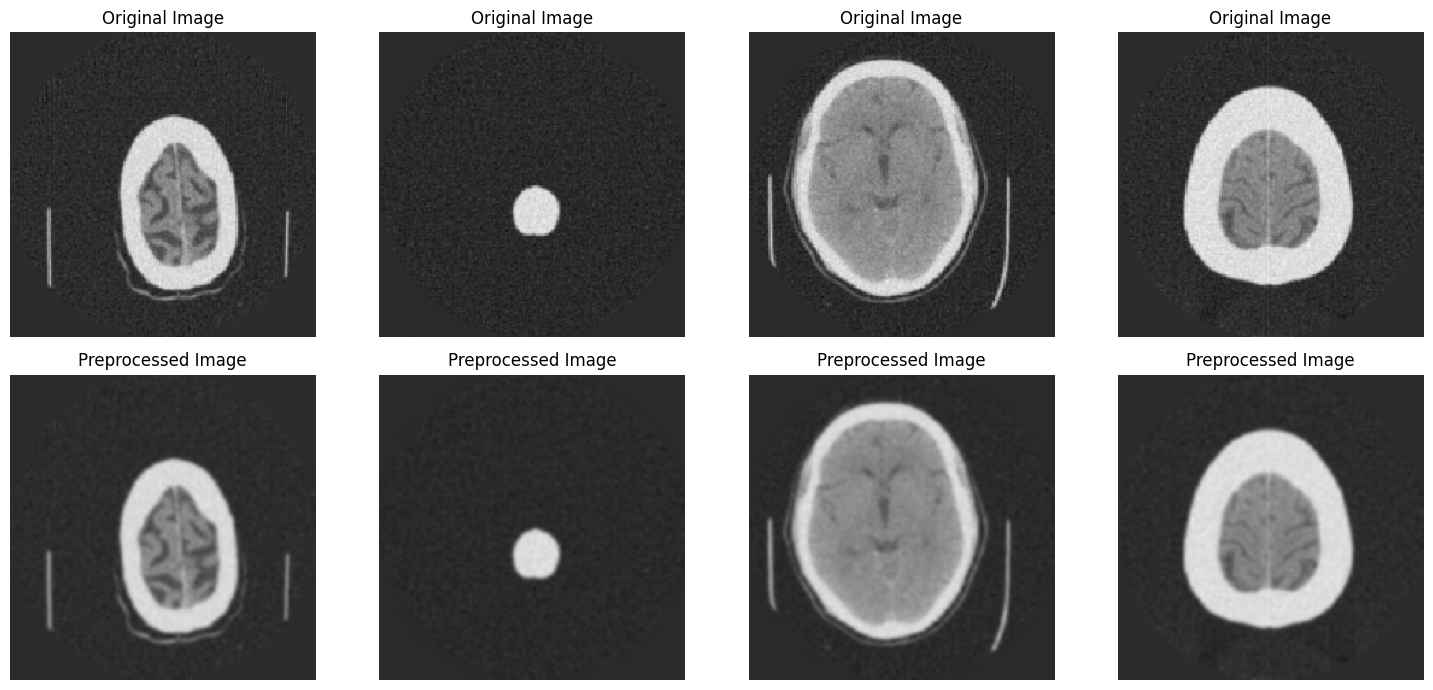

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels from the generator
batch = next(validation_generator)

# Extract the images from the batch
images = batch[0]  # Assuming the batch size is 4
images = np.clip(images, 0, 255) / 255.0


# Preprocess the images
preprocessed_images = [denoise_gaussian_image(image) for image in images]


# Display the images before and after preprocessing
fig, axes = plt.subplots(nrows=2, ncols=len(images), figsize=(15, 7))

for i, image in enumerate(images):
    axes[0, i].imshow(image)
    axes[0, i].axis('off')
    axes[0, i].set_title('Original Image')

for i, image in enumerate(preprocessed_images):
    axes[1, i].imshow(image)
    print(image.dtype)
    axes[1, i].axis('off')
    axes[1, i].set_title('Preprocessed Image')

plt.tight_layout()
plt.show()

In [ ]:
class Block(tf.keras.Model):
    def __init__(self, filters, kernel_size, repetitions, pool_size=2, strides=2):
        super(Block, self).__init__()
        self.filters =filters
        self.kernel_size = kernel_size
        self.repetitions = repetitions

        # Define a conv2D_0, conv2D_1, etc based on the number of repetitions
        for i in range(self.repetitions):

            # Define a Conv2D layer, specifying filters, kernel_size, activation and padding.
            vars(self)[f'conv2D_{i}'] = tf.keras.layers.Conv2D(self.filters,self.kernel_size,activation='relu',padding="same")

        # Define the max pool layer that will be added after the Conv2D blocks
        self.max_pool = tf.keras.layers.MaxPooling2D(pool_size, strides=strides)

    def call(self, inputs):
        # access the class's conv2D_0 layer
        conv2D_0 = vars(self)['conv2D_0']

        # Connect the conv2D_0 layer to inputs
        x = conv2D_0(inputs)

        # for the remaining conv2D_i layers from 1 to `repetitions` they will be connected to the previous layer
        for i in range(1,self.repetitions):
            # access conv2D_i by formatting the integer `i`. (hint: check how these were saved using `vars()` earlier)
            conv2D_i = vars(self)[f'conv2D_{i}']

            # Use the conv2D_i and connect it to the previous layer
            x = conv2D_i(x)

        # Finally, add the max_pool layer
        max_pool = self.max_pool(x)

        return max_pool

In [ ]:
class VGG(tf.keras.Model):

    def __init__(self):
        super(VGG, self).__init__()


        # Creating blocks of VGG with the following
        # (filters, kernel_size, repetitions) configurations
        self.block_a = Block(filters=64, kernel_size=3, repetitions=2)
        self.block_b = Block(filters=128, kernel_size=3, repetitions=2)
        self.block_c = Block(filters=256, kernel_size=3, repetitions=3)
        self.block_d = Block(filters=512, kernel_size=3, repetitions=3)
        self.block_e = Block(filters=512, kernel_size=3, repetitions=3)

        # Classification head
        # Define a Flatten layer
        self.flatten = tf.keras.layers.Flatten()
        # Create a Dense layer with 256 units and ReLU as the activation function
        self.fc = tf.keras.layers.Dense(256,activation='relu')
        # Add a dropout layer with 0.5 dropout rate
        self.dropout = tf.keras.layers.Dropout(0.5)
        # Finally add the binary classifier using a Dense layer
        self.classifier = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        # Apply denoising
        inputs = self.denoising(inputs)

        # Chain all the layers one after the other
        x = self.block_a(inputs)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.block_e(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.classifier(x)
        return x


### Train model

In [ ]:
def train_model():
  optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
  )

  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
  )

  model = VGG()
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping]
  )

  return model

### Get predictions

In [ ]:
def get_predictions(model, data_gen):
    preds = model.predict(data_gen)
    preds_binary = (preds > 0.5).astype(int)

    return preds_binary

### Classification Report

In [ ]:
def get_classification_report(y_test, y_pred):
  accuracy = metrics.accuracy_score(y_test,y_pred)

  print("Accuracy of model=",accuracy)

  return classification_report(y_test, y_pred)

### Run experiments

In [ ]:
import warnings
warnings.filterwarnings('ignore')

model = train_model()

Epoch 1/50


AttributeError: Exception encountered when calling GaussianDenoising.call().

[1mmodule 'tensorflow._api.v2.image' has no attribute 'estimate_sigma'[0m

Arguments received by GaussianDenoising.call():
  • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)

In [ ]:
def get_test_data():
    test_gens = {}
    for nl in TEST_NOISE_LEVELS:
        test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
        n = str.replace(str(nl), '.', '_')

        test_generator = test_datagen.flow_from_directory(
            test_path+n,
            target_size=(224, 224),
            batch_size=4,
            class_mode='binary'
        )

        test_gens[nl] = test_generator

    return test_gens

In [ ]:
noise_data_gens = get_test_data()

Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
# Define the class names
class_names = ['Hemorrhage', 'No Hemorrhage']

accuracies = []
all_trues = []
all_preds = []

for noise_level in TEST_NOISE_LEVELS:
    y_pred = get_predictions(model, noise_data_gens[noise_level])
    labels = noise_data_gens[noise_level].labels
    accuracy = metrics.accuracy_score(labels, y_pred)
    print(f"Accuracy of model on noise level {noise_level} = {accuracy}")
    accuracies.append(accuracy)
    all_trues.extend(labels)
    all_preds.extend(y_pred)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Accuracy of model on noise level 0 = 0.48375
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Accuracy of model on noise level 0.25 = 0.505
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Accuracy of model on noise level 0.75 = 0.4725
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
Accuracy of model on noise level 1 = 0.51875
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Accuracy of model on noise level 1.5 = 0.50375


In [ ]:
# Get classification report
class_report = get_classification_report(all_trues, all_preds)
# Convert noise level to a valid string for the filename
filename = f"report_{str(NOISE_LEVEL).replace('.', '_')}_level.txt"
# Save classification report
with open(f"data/outputs/classification_reports/{filename}", "w") as file:
    file.write(class_report)

In [ ]:
# show confusion matrix
confusion_matrix = metrics.confusion_matrix(all_trues, all_preds)
print(confusion_matrix)